In [70]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d
from scipy.ndimage import gaussian_filter
import skimage.filters

def get_gaussian_filter(filter_size: int, sigma: float) -> np.ndarray:
    filter_1d = gaussian(filter_size, sigma)
    filter_2d = np.outer(filter_1d, filter_1d)
    return filter_2d

def apply_filter(target: np.ndarray, filter: np.ndarray) -> np.ndarray:
    pad_h = filter.shape[0] - 1
    pad_w = filter.shape[1] - 1
    target_padded = np.pad(target, (pad_h, pad_w))
    target_filtered = convolve2d(filter, target_padded,
                                 mode="valid",
                                 boundary="fill", fillvalue=0.0,
                                 )
    output = target_filtered[pad_h // 2:-pad_h // 2,
                             pad_w // 2:-pad_w // 2]
    return output

def alternative_gaussian_filter(target: np.ndarray, sigma: float, z_score: float) -> np.ndarray:
  #target_filtered = gaussian_filter(target, sigma)
  target_filtered = skimage.filters.gaussian(target, sigma, mode="nearest")
  target_filtered /= np.sum(target_filtered)

  if z_score > 0.0:
    mean = np.mean(target_filtered)
    std = np.std(target_filtered)
    thresh = mean + z_score * std
    throw_idx = target_filtered < thresh
    keep_idx = np.logical_not(throw_idx)

    target_filtered[keep_idx] += np.sum(target_filtered[throw_idx]) / np.sum(keep_idx)
    target_filtered[throw_idx] = 0.0
    
  return target_filtered

def plot_grid(ax, target, color="red"):
  # See: https://stackoverflow.com/a/38994970
  ax.set_yticks(np.arange(0, target.shape[0], 1))
  ax.set_xticks(np.arange(0, target.shape[1], 1))

  ax.set_xticklabels(np.arange(1, target.shape[0], 1))
  ax.set_yticklabels(np.arange(1, target.shape[1], 1))

  ax.set_yticks(np.arange(-.5, target.shape[0], 1), minor=True)
  ax.set_xticks(np.arange(-.5, target.shape[1], 1), minor=True)

  ax.grid(which="minor", color=color, alpha=0.3, linewidth=2)

def plot_new(target: np.ndarray, filter: np.ndarray, target_filtered: np.ndarray,
         sigma: float, show_grid: bool = True):
  target_filtered_normalized = target_filtered / np.sum(target_filtered)

  fig, axs = plt.subplots(1, 5, figsize=(17.5, 4.5))
  fig.suptitle("New approach")
  axs[0].set_title("Input (size {}x{}".format(*target.shape))
  axs[1].set_title("Filter (size {}x{})\nSigma: {:.2f}".format(*filter.shape, sigma))
  axs[2].set_title("Output (size {}x{})".format(*target_filtered.shape))
  axs[3].set_title("Output histogram\nSum: {:.2f}\nRange: [{:.3f}, {:.3f}]".format(
      np.sum(target_filtered),
      np.min(target_filtered),
      np.max(target_filtered)
  ))
  axs[4].set_title("Normalized output histogram\nSum: {:.2f}\nRange: [{:.3f}, {:.3f}]".format(
      np.sum(target_filtered_normalized),
      np.min(target_filtered_normalized),
      np.max(target_filtered_normalized)
  ))

  axs[0].imshow(target, cmap="gray")
  if show_grid:
    plot_grid(axs[0], target, "red")
  axs[1].imshow(filter, cmap="jet")
  if show_grid:
    plot_grid(axs[1], filter, "white")
  cmap = mpl.cm.get_cmap("jet")
  cmap.set_bad(color="white", alpha=1.0)
  axs[2].imshow(target_filtered, cmap=cmap)
  if show_grid:
    plot_grid(axs[2], target_filtered, "black")
  axs[3].hist(target_filtered, bins=20, alpha=0.5,
              log=False, histtype="stepfilled")
  axs[4].hist(target_filtered_normalized, bins=20, alpha=0.5,
              log=False, histtype="stepfilled")
  target_alternative_filtered_masked = np.ma.masked_where(target_alternative_filtered == 0.0, target_alternative_filtered)
  return fig

def plot_old(target: np.ndarray, target_filtered: np.ndarray,
             target_filtered_thresh: np.ndarray,
             sigma: float, z_score: float,
             show_grid: bool = True):
  target_filtered_normalized = target_filtered / np.sum(target_filtered)

  fig, axs = plt.subplots(1, 5, figsize=(17.5, 4.5))
  fig.suptitle("Previous approach")
  axs[0].set_title("Input (size {}x{}".format(*target.shape))
  axs[1].set_title("Output (size {}x{})\nSigma: {:.2f}".format(*filter.shape, sigma))
  axs[2].set_title("Thresh. output (size {}x{})\nSigma: {:.2f}, Z-score:{:.2f}".format(*filter.shape, sigma, z_score))
  axs[3].set_title("Thresh. output histogram\nSum: {:.2f}\nRange: [{:.3f}, {:.3f}]".format(
      np.sum(target_filtered_thresh),
      np.min(target_filtered_thresh),
      np.max(target_filtered_thresh)
  ))
  axs[4].set_title("Normalized thresh. output histogram\nSum: {:.2f}\nRange: [{:.3f}, {:.3f}]".format(
      np.sum(target_filtered_thresh),
      np.min(target_filtered_thresh),
      np.max(target_filtered_thresh)
  ))

  axs[0].imshow(target, cmap="gray")
  if show_grid:
    plot_grid(axs[0], target, "red")

  cmap = mpl.cm.get_cmap("jet")
  cmap.set_bad(color="white", alpha=1.0)

  axs[1].imshow(target_filtered, cmap=cmap)
  if show_grid:
    plot_grid(axs[1], target_filtered, "black")

  axs[2].imshow(target_filtered_thresh, cmap=cmap) 
  if show_grid:
    plot_grid(axs[2], target, "black")

  axs[3].hist(target_filtered, bins=20, alpha=0.5,
              log=False, histtype="stepfilled")
  axs[4].hist(target_filtered_normalized, bins=20, alpha=0.5,
              log=False, histtype="stepfilled")
  return fig

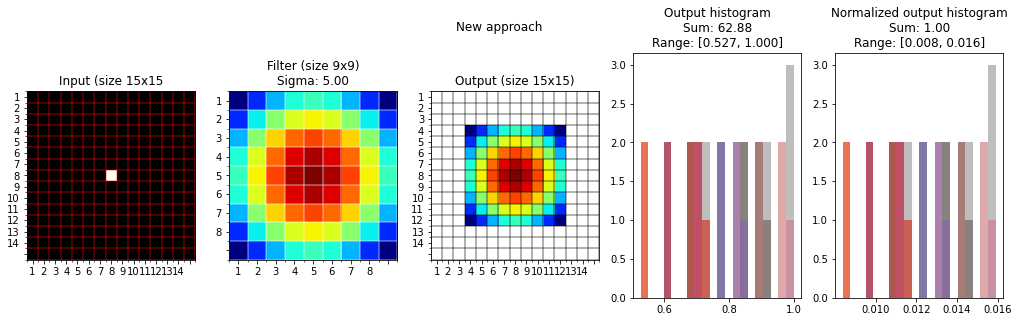

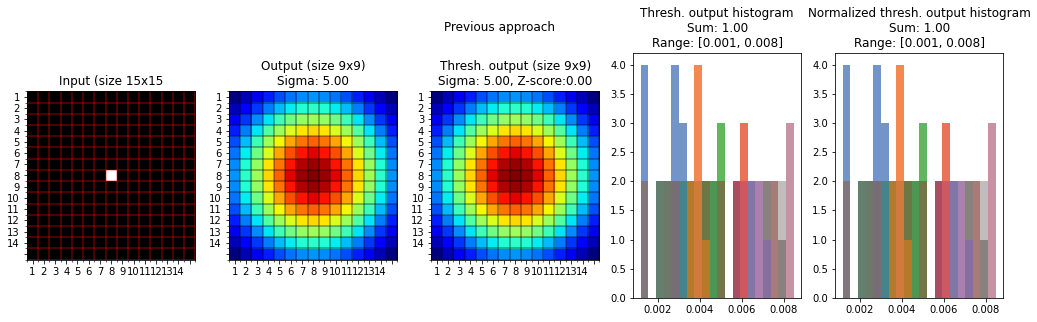

In [72]:
#@markdown Input image
image_size = 15#@param {type:"integer"}
#@markdown New approach
filter_size =  9#@param {type:"integer"}
sigma =  5#@param {type:"number"}

#@markdown Old approach
alt_sigma =  5#@param {type:"number"}
alt_z_score = 0#@param {type:"number"}

#@markdown Plot
mask_out_threshold = 0.0#@param {type:"number"}

if image_size % 2 == 0:
  image_size += 1

target = np.zeros((image_size, image_size))
target[image_size // 2, image_size // 2] = 1.0
filter = get_gaussian_filter(filter_size, sigma)
target_filtered = apply_filter(target, filter)
target_masked = np.ma.masked_less_equal(target_filtered,
                                        mask_out_threshold,
                                        )
fig = plot_new(target, filter, target_masked, sigma)

target_filtered = alternative_gaussian_filter(target, alt_sigma, 0.0,)
target_filtered_masked = np.ma.masked_less_equal(target_filtered,
                                        mask_out_threshold,
                                        )
target_filtered_thresh = alternative_gaussian_filter(target, alt_sigma, alt_z_score,)
target_filtered_thresh_masked = np.ma.masked_less_equal(target_filtered_thresh,
                                        mask_out_threshold,
                                        )
fig = plot_old(target, target_filtered_masked, target_filtered_thresh_masked, alt_sigma, alt_z_score)

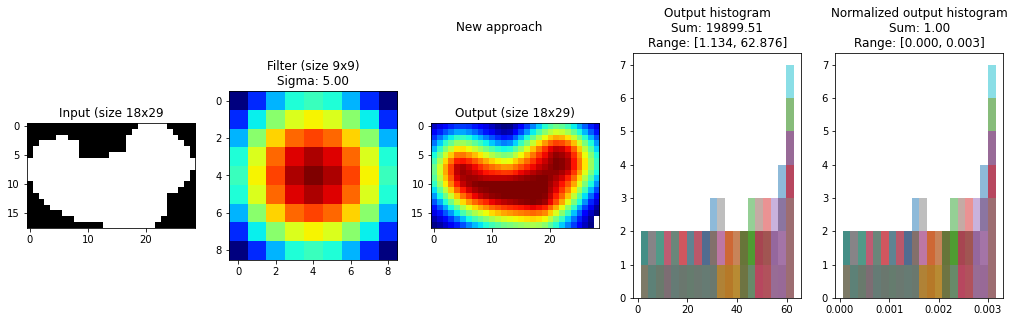

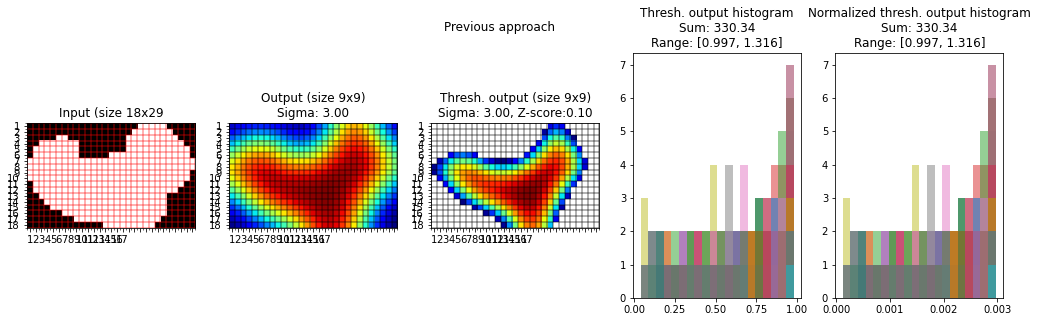

In [67]:
#@markdown Input image
image_size = 15#@param {type:"integer"}
#@markdown New approach
filter_size =  9#@param {type:"integer"}
sigma =  5#@param {type:"number"}

#@markdown Old approach
alt_sigma =  3#@param {type:"number"}
alt_z_score = 0.1#@param {type:"number"}

#@markdown Plot
mask_out_threshold = 0.0#@param {type:"number"}

blob = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype="float32")

filter = get_gaussian_filter(filter_size, sigma)
target_filtered = apply_filter(blob, filter)
target_masked = np.ma.masked_less_equal(target_filtered,
                                        mask_out_threshold,
                                        )
fig = plot_new(blob, filter, target_masked, sigma, show_grid=False)

target_filtered = alternative_gaussian_filter(blob, alt_sigma, 0.0,)
target_filtered_masked = np.ma.masked_less_equal(target_filtered,
                                        mask_out_threshold,
                                        )

target_filtered_thresh = alternative_gaussian_filter(blob, alt_sigma, alt_z_score,)
target_filtered_thresh_masked = np.ma.masked_less_equal(target_filtered_thresh,
                                        mask_out_threshold,
                                        )
fig = plot_old(blob, target_filtered_masked, target_filtered_thresh_masked, alt_sigma, alt_z_score)